In [151]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Handle OneHotEncoder compatibility
encoder_args = {}
sk_version = tuple(map(int, sklearn.__version__.split(".")))
if sk_version >= (1, 2):
    encoder_args['sparse_output'] = False
else:
    encoder_args['sparse'] = False

# 1. Load UCI HAR dataset
def load_ucihar_dataset(base_path='E:/dataset/HAR/UCI-HAR'):
    input_signals = [
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
        "total_acc_x_", "total_acc_y_", "total_acc_z_"
    ]

    def read_signals(folder):
        signals = []
        for signal in input_signals:
            path = os.path.join(base_path, folder, "Inertial Signals", signal + folder + ".txt")
            signals.append(np.loadtxt(path))
        return np.transpose(np.array(signals), (1, 2, 0))

    def read_labels(folder):
        path = os.path.join(base_path, folder, "y_" + folder + ".txt")
        return np.loadtxt(path).astype(int) - 1

    X_train = read_signals("train")
    y_train = read_labels("train")
    X_test = read_signals("test")
    y_test = read_labels("test")

    return X_train, y_train, X_test, y_test

In [152]:
# 2. Preprocessing
def preprocess_data(X_train, y_train, X_test, y_test):
    num_features = X_train.shape[2]
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train.reshape(-1, num_features)).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, num_features)).reshape(X_test.shape)

    encoder = OneHotEncoder(**encoder_args)
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test = encoder.transform(y_test.reshape(-1, 1))

    return X_train, y_train, X_test, y_test

In [153]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Basic Residual Block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(dropout)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.bn2(self.conv2(out))
        out = self.dropout2(out)
        out += self.shortcut(x)
        return F.relu(out)

# Positional Encoding for 1D sequence
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, embed_dim]
        self.register_buffer('pe', pe)

    def forward(self, x):  # x: [B, T, E]
        return x + self.pe[:, :x.size(1), :]

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):  # x: [B, T, E]
        residual = x
        x = self.attn(x, x, x)[0]
        x = self.norm1(x + residual)

        residual = x
        x = self.ff(x)
        x = self.norm2(x + residual)
        return x

# 전체 모델
class TeacherResTrans(nn.Module):
    def __init__(self, input_channels, seq_len, num_classes,
                 embed_dim=128, num_layers=4, num_heads=4, ff_dim=256, dropout=0.1):
        super().__init__()
        self.initial_conv = nn.Conv1d(input_channels, embed_dim, kernel_size=3, padding=1)
        self.init_norm = nn.LayerNorm(embed_dim)

        self.pos_encoder = PositionalEncoding(embed_dim, max_len=seq_len)

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.ModuleDict({
                "resnet": BasicBlock(embed_dim, embed_dim, dropout=dropout),
                "transformer": TransformerBlock(embed_dim, num_heads, ff_dim, dropout=dropout)
            }))

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.output_norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):  # x: [B, C, T]
        x = self.initial_conv(x)            # [B, E, T]
        x = x.permute(0, 2, 1)              # [B, T, E]
        x = self.init_norm(x)

        for layer in self.layers:
            x = x.permute(0, 2, 1)          # [B, E, T] → ResNet
            x = layer["resnet"](x)
            x = x.permute(0, 2, 1)          # [B, T, E] → Transformer
            x = self.pos_encoder(x)
            x = layer["transformer"](x)

        x = x.permute(0, 2, 1)              # [B, E, T]
        x = self.global_pool(x).squeeze(-1) # [B, E]
        x = self.output_norm(x)
        return self.classifier(x)           # [B, num_classes]



In [154]:
class StudentNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(9, 32, 16, padding=8)
        self.conv2 = nn.Conv1d(32, 64, 16, padding=8)
        self.pool = nn.MaxPool1d(2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.global_pool(x).squeeze(-1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [155]:
# 4. Distillation Loss
def distillation_loss(student_logits, teacher_logits, true_labels, T, alpha):
    kd_loss = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction='batchmean'
    ) * (T * T)
    ce_loss = F.cross_entropy(student_logits, true_labels)
    return alpha * ce_loss + (1 - alpha) * kd_loss


In [156]:
# 5. Train functions
def train(model, dataloader, optimizer, teacher=None, T=2.0, alpha=0.5):
    model.train()
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(X_batch)
        if teacher:
            with torch.no_grad():
                teacher_outputs = teacher(X_batch)
            loss = distillation_loss(outputs, teacher_outputs, y_batch.argmax(dim=1), T, alpha)
        else:
            loss = F.cross_entropy(outputs, y_batch.argmax(dim=1))
        loss.backward()
        optimizer.step()

def evaluate(model, dataloader, name="Model"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.argmax(dim=1)  # Convert one-hot to label
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1).cpu().numpy()
            labels = y_batch.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    print(f"\nClassification Report for {name}:")
    print(classification_report(all_labels, all_preds))

    print(f"\nConfusion Matrix for {name}:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

def test_model(model, dataloader, name="Model"):
    print(f"\nEvaluating {name}...")
    evaluate(model, dataloader, name=name)


In [157]:
EPOCHE_T = 20
EPOCHE_S = 40

In [158]:
# 7. Main execution
X_train, y_train, X_test, y_test = load_ucihar_dataset()
X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

teacher = TeacherNet(num_classes=6).to(DEVICE)
optimizer = torch.optim.Adam(teacher.parameters(), lr=0.001)

print("Training Teacher...")
for epoch in range(EPOCHE_T):
    print(f"Epoch {epoch + 1}/{EPOCHE_T} - Teacher")
    train(teacher, train_loader, optimizer)

student = StudentNet(num_classes=6).to(DEVICE)
optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
print("\nTraining Student (Distilled)...")
for epoch in range(EPOCHE_S):
    print(f"Epoch {epoch + 1}/{EPOCHE_S} - Student")
    train(student, train_loader, optimizer, teacher=teacher, T=2.0, alpha=0.5)

Training Teacher...
Epoch 1/20 - Teacher
Epoch 2/20 - Teacher
Epoch 3/20 - Teacher
Epoch 4/20 - Teacher
Epoch 5/20 - Teacher
Epoch 6/20 - Teacher
Epoch 7/20 - Teacher
Epoch 8/20 - Teacher
Epoch 9/20 - Teacher
Epoch 10/20 - Teacher
Epoch 11/20 - Teacher
Epoch 12/20 - Teacher
Epoch 13/20 - Teacher
Epoch 14/20 - Teacher
Epoch 15/20 - Teacher
Epoch 16/20 - Teacher
Epoch 17/20 - Teacher
Epoch 18/20 - Teacher
Epoch 19/20 - Teacher
Epoch 20/20 - Teacher

Training Student (Distilled)...
Epoch 1/40 - Student
Epoch 2/40 - Student
Epoch 3/40 - Student
Epoch 4/40 - Student
Epoch 5/40 - Student
Epoch 6/40 - Student
Epoch 7/40 - Student
Epoch 8/40 - Student
Epoch 9/40 - Student
Epoch 10/40 - Student
Epoch 11/40 - Student
Epoch 12/40 - Student
Epoch 13/40 - Student
Epoch 14/40 - Student
Epoch 15/40 - Student
Epoch 16/40 - Student
Epoch 17/40 - Student
Epoch 18/40 - Student
Epoch 19/40 - Student
Epoch 20/40 - Student
Epoch 21/40 - Student
Epoch 22/40 - Student
Epoch 23/40 - Student
Epoch 24/40 - Stude


Evaluating Teacher...

Classification Report for Teacher:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       496
           1       0.97      0.94      0.95       471
           2       0.91      1.00      0.95       420
           3       0.79      0.86      0.82       491
           4       0.88      0.79      0.83       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947


Confusion Matrix for Teacher:


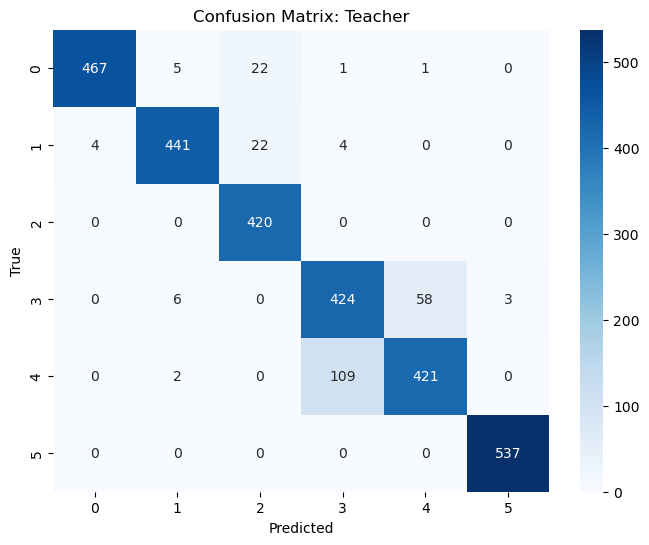


Evaluating Student...

Classification Report for Student:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       496
           1       0.97      0.99      0.98       471
           2       0.98      0.99      0.98       420
           3       0.80      0.84      0.82       491
           4       0.86      0.80      0.83       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947


Confusion Matrix for Student:


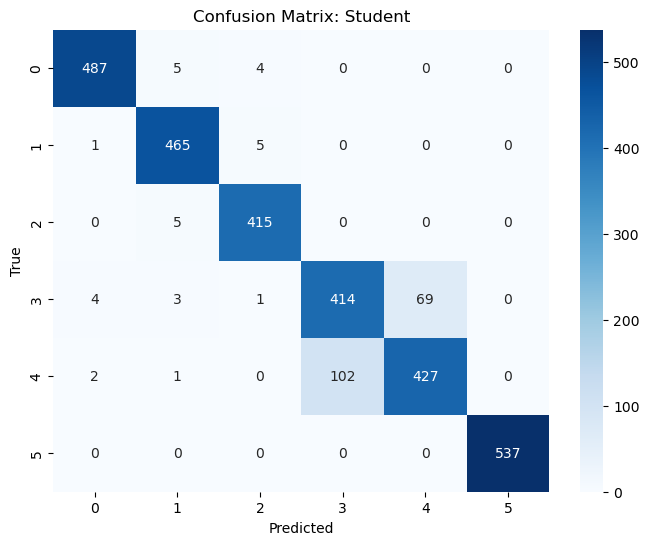

In [159]:
test_model(teacher, test_loader, "Teacher")
test_model(student, test_loader, "Student")